In [1]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader
import wandb
import h5py

import sys
sys.path.append('../../../src/')
from build_model import fpn_resnet50_classification
from train_functions import train_epochs
from dataset_functions import split_train_valid, list_to_dict, viz_dataloader, hdf5_dataset
from visualization_functions import show_images

ModuleNotFoundError: No module named 'build_model'

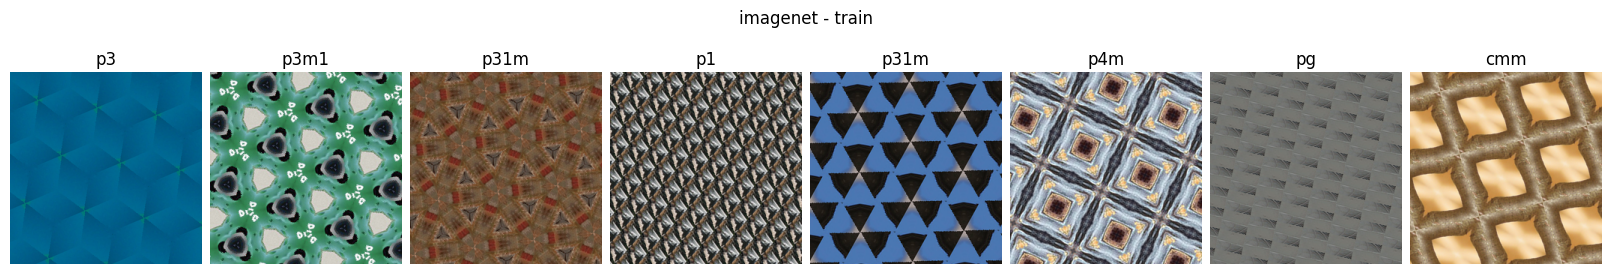

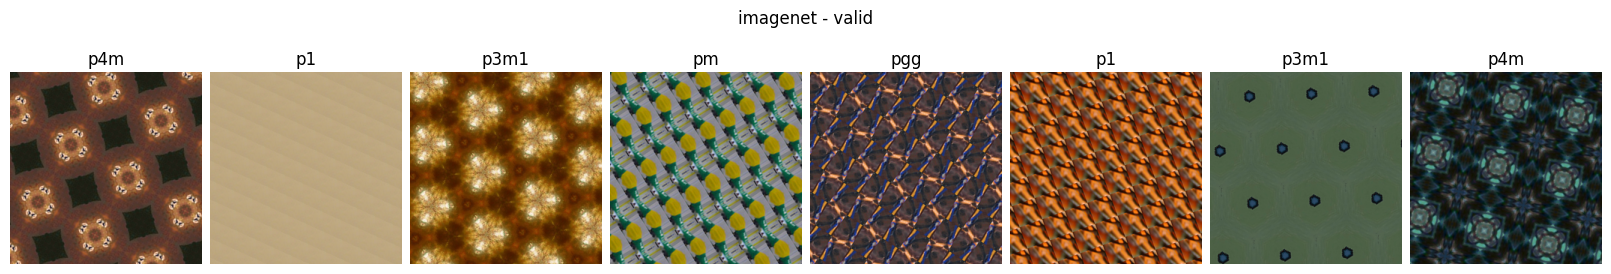

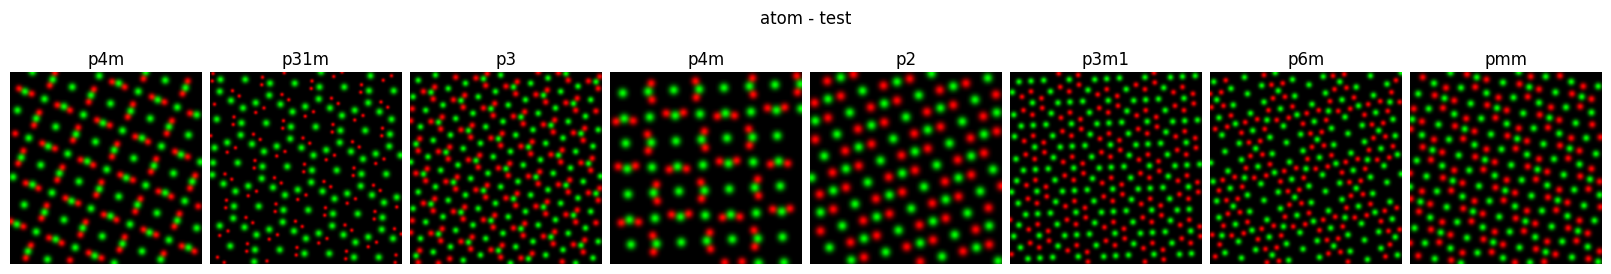

In [ ]:
symmetry_classes = ['p1', 'p2', 'pm', 'pg', 'cm', 'pmm', 'pmg', 'pgg', 'cmm', 
                 'p4', 'p4m', 'p4g', 'p3', 'p3m1', 'p31m', 'p6', 'p6m']
label_converter = list_to_dict(symmetry_classes)

# imagenet
train_ds = hdf5_dataset('../../../datasets/imagenet_v4_rot_10m_train_unchunked.h5', folder='train', transform=transforms.ToTensor())
train_dl = DataLoader(train_ds, batch_size=600, shuffle=True, num_workers=4)
viz_dataloader(train_dl, label_converter=label_converter, title='imagenet - train')

# imagenet
valid_ds = hdf5_dataset('../../../datasets/imagenet_v4_rot_2m_valid_unchunked.h5', folder='valid', transform=transforms.ToTensor())
valid_dl = DataLoader(valid_ds, batch_size=600, shuffle=False, num_workers=4)
viz_dataloader(valid_dl, label_converter=label_converter, title='imagenet - valid')

# atom
test_ds = hdf5_dataset('../../../datasets/atom_v4_rot_2m_unchunked.h5', folder='test', transform=transforms.ToTensor())
test_dl = DataLoader(test_ds, batch_size=600, shuffle=False, num_workers=4)
viz_dataloader(test_dl, label_converter=label_converter, title='atom - test')

In [3]:
model = fpn_resnet50_classification(in_channels=3, n_classes=17)
print(model)
outputs = model.fpn(torch.randn(2,3,256,256))
for o in outputs:
    print(o.shape)
outputs = model(torch.randn(2,3,256,256))
print(outputs.shape)

fpn_resnet50_classification(
  (fpn): feature_pyramid_network(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (downsample): Sequential(
          (0

/home/yichen/anaconda3/envs/symmetry/lib/python3.10/site-packages/torch/nn/functional.py:3769: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


# train

In [4]:
wandb.login()
config = {
    'dataset': '10 million datasets',
    'model': 'fpn_resnet50_yichen',
    'loss_func': 'CrossEntropyLoss', # nn.MSELoss()
    'optimizer': 'Adam',
    'scheduler': 'OneCycleLR',
}

NAME = '01182024-benchmark-fpn_resnet50-v4_10m'

proj_name = 'Understanding-Experimental-Images-by-Identifying-Symmetries-with-Deep-Learning'
wandb.init(project=proj_name, entity='yig319', name=NAME, id=NAME, group='benchmark', save_code=True, config=config)
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: yig319. Use `wandb login --relogin` to force relogin


In [5]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
lr = 1e-3
max_epochs = 20

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, epochs=max_epochs, max_lr=lr, steps_per_epoch=len(train_dl))

history = train_epochs(model, loss_func, optimizer, device, train_dl, valid_dl, test_dl, epochs=max_epochs, 
                       scheduler=scheduler, model_dir=f'../../../saved_models/{NAME}/', tracking=True)

Epoch: 1/20


  0%|          | 0/16667 [00:00<?, ?it/s]/home/yichen/anaconda3/envs/symmetry/lib/python3.10/site-packages/torch/nn/functional.py:3769: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
100%|██████████| 16667/16667 [5:03:13<00:00,  1.09s/it]  


Training: Loss: 0.3640, Accuracy: 88.5895%, Time: 303.2190mins


100%|██████████| 3334/3334 [31:57<00:00,  1.74it/s]


Validation : Loss : 0.0695, Accuracy: 97.7830%, Time: 31.97mins


100%|██████████| 3388/3388 [33:13<00:00,  1.70it/s]


Validation : Loss : 3.8881, Accuracy: 38.4363%, Time: 33.23mins
Epoch: 2/20


100%|██████████| 16667/16667 [5:04:29<00:00,  1.10s/it]  


Training: Loss: 0.0469, Accuracy: 98.6213%, Time: 304.4885mins


100%|██████████| 3334/3334 [32:00<00:00,  1.74it/s]


Validation : Loss : 0.0296, Accuracy: 99.0811%, Time: 32.01mins


100%|██████████| 3388/3388 [32:32<00:00,  1.73it/s]


Validation : Loss : 3.8642, Accuracy: 52.4973%, Time: 32.55mins
Epoch: 3/20


100%|██████████| 16667/16667 [5:05:03<00:00,  1.10s/it]  


Training: Loss: 0.0245, Accuracy: 99.2805%, Time: 305.0574mins


100%|██████████| 3334/3334 [32:23<00:00,  1.72it/s]


Validation : Loss : 0.0182, Accuracy: 99.4107%, Time: 32.39mins


100%|██████████| 3388/3388 [34:11<00:00,  1.65it/s]


Validation : Loss : 4.1737, Accuracy: 45.8967%, Time: 34.18mins
Epoch: 4/20


100%|██████████| 16667/16667 [5:06:03<00:00,  1.10s/it]  


Training: Loss: 0.0163, Accuracy: 99.5202%, Time: 306.0637mins


100%|██████████| 3334/3334 [33:53<00:00,  1.64it/s]


Validation : Loss : 0.0134, Accuracy: 99.5745%, Time: 33.89mins


100%|██████████| 3388/3388 [34:41<00:00,  1.63it/s]


Validation : Loss : 3.8963, Accuracy: 54.8744%, Time: 34.69mins
Epoch: 5/20


100%|██████████| 16667/16667 [5:06:20<00:00,  1.10s/it]  


Training: Loss: 0.0119, Accuracy: 99.6460%, Time: 306.3374mins


100%|██████████| 3334/3334 [34:06<00:00,  1.63it/s]


Validation : Loss : 0.0095, Accuracy: 99.7065%, Time: 34.10mins


100%|██████████| 3388/3388 [34:26<00:00,  1.64it/s]


Validation : Loss : 3.5446, Accuracy: 56.1240%, Time: 34.44mins
Epoch: 6/20


100%|██████████| 16667/16667 [5:06:38<00:00,  1.10s/it]  


Training: Loss: 0.0091, Accuracy: 99.7275%, Time: 306.6459mins


100%|██████████| 3334/3334 [34:09<00:00,  1.63it/s]


Validation : Loss : 0.0084, Accuracy: 99.7299%, Time: 34.16mins


100%|██████████| 3388/3388 [34:12<00:00,  1.65it/s]


Validation : Loss : 3.4756, Accuracy: 55.5434%, Time: 34.21mins
Epoch: 7/20


100%|██████████| 16667/16667 [5:06:03<00:00,  1.10s/it]  


Training: Loss: 0.0070, Accuracy: 99.7859%, Time: 306.0537mins


100%|██████████| 3334/3334 [34:17<00:00,  1.62it/s]


Validation : Loss : 0.0057, Accuracy: 99.8160%, Time: 34.30mins


100%|██████████| 3388/3388 [34:33<00:00,  1.63it/s]


Validation : Loss : 3.8868, Accuracy: 50.4383%, Time: 34.55mins
Epoch: 8/20


100%|██████████| 16667/16667 [5:06:02<00:00,  1.10s/it]  


Training: Loss: 0.0057, Accuracy: 99.8238%, Time: 306.0388mins


100%|██████████| 3334/3334 [34:10<00:00,  1.63it/s]


Validation : Loss : 0.0051, Accuracy: 99.8311%, Time: 34.18mins


100%|██████████| 3388/3388 [34:38<00:00,  1.63it/s]


Validation : Loss : 3.7630, Accuracy: 50.7627%, Time: 34.64mins
Epoch: 9/20


100%|██████████| 16667/16667 [5:06:56<00:00,  1.10s/it]  


Training: Loss: 0.0047, Accuracy: 99.8538%, Time: 306.9445mins


100%|██████████| 3334/3334 [34:19<00:00,  1.62it/s]


Validation : Loss : 0.0052, Accuracy: 99.8382%, Time: 34.33mins


100%|██████████| 3388/3388 [34:45<00:00,  1.62it/s]


Validation : Loss : 3.9026, Accuracy: 55.5286%, Time: 34.76mins
Epoch: 10/20


100%|██████████| 16667/16667 [5:06:24<00:00,  1.10s/it]  


Training: Loss: 0.0039, Accuracy: 99.8732%, Time: 306.4152mins


100%|██████████| 3334/3334 [34:27<00:00,  1.61it/s]


Validation : Loss : 0.0043, Accuracy: 99.8626%, Time: 34.46mins


100%|██████████| 3388/3388 [34:42<00:00,  1.63it/s]


Validation : Loss : 3.6498, Accuracy: 58.8293%, Time: 34.70mins
Epoch: 11/20


100%|██████████| 16667/16667 [5:06:19<00:00,  1.10s/it]  


Training: Loss: 0.0033, Accuracy: 99.8938%, Time: 306.3280mins


100%|██████████| 3334/3334 [34:18<00:00,  1.62it/s]


Validation : Loss : 0.0040, Accuracy: 99.8727%, Time: 34.31mins


100%|██████████| 3388/3388 [34:42<00:00,  1.63it/s]


Validation : Loss : 4.2054, Accuracy: 55.9963%, Time: 34.70mins
Epoch: 12/20


100%|██████████| 16667/16667 [5:07:24<00:00,  1.11s/it]  


Training: Loss: 0.0027, Accuracy: 99.9090%, Time: 307.4089mins


100%|██████████| 3334/3334 [34:21<00:00,  1.62it/s]


Validation : Loss : 0.0039, Accuracy: 99.8827%, Time: 34.36mins


100%|██████████| 3388/3388 [34:33<00:00,  1.63it/s]


Validation : Loss : 4.1646, Accuracy: 56.5348%, Time: 34.56mins
Epoch: 13/20


100%|██████████| 16667/16667 [5:06:37<00:00,  1.10s/it]  


Training: Loss: 0.0023, Accuracy: 99.9218%, Time: 306.6259mins


100%|██████████| 3334/3334 [34:18<00:00,  1.62it/s]


Validation : Loss : 0.0035, Accuracy: 99.8942%, Time: 34.31mins


100%|██████████| 3388/3388 [34:29<00:00,  1.64it/s]


Validation : Loss : 4.3160, Accuracy: 59.7346%, Time: 34.49mins
Epoch: 14/20


100%|██████████| 16667/16667 [5:08:48<00:00,  1.11s/it]  


Training: Loss: 0.0019, Accuracy: 99.9339%, Time: 308.8076mins


100%|██████████| 3334/3334 [34:17<00:00,  1.62it/s]


Validation : Loss : 0.0033, Accuracy: 99.9008%, Time: 34.29mins


100%|██████████| 3388/3388 [34:15<00:00,  1.65it/s]


Validation : Loss : 4.5867, Accuracy: 58.6604%, Time: 34.26mins
Epoch: 15/20


100%|██████████| 16667/16667 [5:06:55<00:00,  1.10s/it]  


Training: Loss: 0.0016, Accuracy: 99.9433%, Time: 306.9324mins


100%|██████████| 3334/3334 [34:20<00:00,  1.62it/s]


Validation : Loss : 0.0030, Accuracy: 99.9126%, Time: 34.34mins


100%|██████████| 3388/3388 [34:44<00:00,  1.63it/s]


Validation : Loss : 4.4768, Accuracy: 58.7448%, Time: 34.74mins
Epoch: 16/20


100%|██████████| 16667/16667 [5:07:15<00:00,  1.11s/it]  


Training: Loss: 0.0014, Accuracy: 99.9507%, Time: 307.2643mins


100%|██████████| 3334/3334 [34:28<00:00,  1.61it/s]


Validation : Loss : 0.0032, Accuracy: 99.9133%, Time: 34.48mins


100%|██████████| 3388/3388 [34:50<00:00,  1.62it/s]


Validation : Loss : 4.9409, Accuracy: 58.6109%, Time: 34.85mins
Epoch: 17/20


100%|██████████| 16667/16667 [5:07:11<00:00,  1.11s/it]  


Training: Loss: 0.0012, Accuracy: 99.9558%, Time: 307.1939mins


100%|██████████| 3334/3334 [34:18<00:00,  1.62it/s]


Validation : Loss : 0.0031, Accuracy: 99.9191%, Time: 34.31mins


100%|██████████| 3388/3388 [34:51<00:00,  1.62it/s]


Validation : Loss : 4.9162, Accuracy: 58.6174%, Time: 34.86mins
Epoch: 18/20


100%|██████████| 16667/16667 [5:06:43<00:00,  1.10s/it]  


Training: Loss: 0.0011, Accuracy: 99.9596%, Time: 306.7234mins


100%|██████████| 3334/3334 [34:04<00:00,  1.63it/s]


Validation : Loss : 0.0031, Accuracy: 99.9195%, Time: 34.07mins


100%|██████████| 3388/3388 [34:14<00:00,  1.65it/s]


Validation : Loss : 5.1804, Accuracy: 58.7312%, Time: 34.24mins
Epoch: 19/20


100%|██████████| 16667/16667 [5:07:10<00:00,  1.11s/it]  


Training: Loss: 0.0011, Accuracy: 99.9621%, Time: 307.1704mins


100%|██████████| 3334/3334 [34:18<00:00,  1.62it/s]


Validation : Loss : 0.0032, Accuracy: 99.9209%, Time: 34.30mins


100%|██████████| 3388/3388 [33:34<00:00,  1.68it/s]


Validation : Loss : 5.2598, Accuracy: 58.9133%, Time: 33.58mins
Epoch: 20/20


100%|██████████| 16667/16667 [5:06:41<00:00,  1.10s/it]  


Training: Loss: 0.0010, Accuracy: 99.9632%, Time: 306.6836mins


100%|██████████| 3334/3334 [32:51<00:00,  1.69it/s]


Validation : Loss : 0.0032, Accuracy: 99.9211%, Time: 32.86mins


100%|██████████| 3388/3388 [32:59<00:00,  1.71it/s]


Validation : Loss : 5.2889, Accuracy: 59.0888%, Time: 32.99mins
